## Подключение библиотек и скриптов

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

import random

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [2]:
# Эта функция используется для уменьшения объема памяти фрейма данных pandas
# Идея состоит в том, чтобы перевести числовой тип в другой, более эффективный для памяти тип
# Например: функции "возраст" должны нуждаться только в типе='np.int8'
# Источник: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
 to reduce memory usage. 
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64) 
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif 'datetime' not in col_type.name:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
class DataPreprocessor:
    def __init__(self):
        self.rooms_by_square = None
        self.medians = None
        self.min_lifesquare = None
        self.max_kitchen_square = None
        self.rooms_by_square = None
        self.max_floor = None
        self.min_house_year = None
        self.healthcare_fill_model = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=232, n_jobs=-1)
        

    def fit(self, df):
        df = df.copy()
        
        self.min_lifesquare = df['LifeSquare'].quantile(.05)
        self.max_kitchen_square = df['KitchenSquare'].quantile(.995)
        
        self.rooms_by_square = [df.loc[df.Rooms == i, 'Square'].quantile(.75) for i in range(1, 5)]
        self.rooms_by_square = [0, *self.rooms_by_square, df['Square'].max()]
        
        self.max_floor = df['Floor'].max()
        
        self.min_house_year = df['HouseYear'].min()
        
        df = self.bin_to_num(df)
        self.healthcare_model_fit(df)

        self.medians = df.median()
        
        
    def transform(self, df):
        df = df.copy()
        
        # LifeSquare
        # Replace outliers with NaN
        df.loc[df['LifeSquare'] < self.min_lifesquare, 'LifeSquare'] = np.NaN
        # fill NaN. 0.72 seems to be the best value, got it by testing with MAE
        df['LifeSquare'].fillna((df['Square'] - df['KitchenSquare']) * 0.72, inplace=True)
        # Switch places if LifeSquare > Square
        df['Square'], df['LifeSquare'] = np.where(df['LifeSquare'] > df['Square'], 
                                          (df['LifeSquare'], df['Square']), 
                                          (df['Square'], df['LifeSquare']))
        
        
        # KitchenSquare
        condition =  (df['KitchenSquare'] < 3) | (df['KitchenSquare'] > self.max_kitchen_square)
        df.loc[condition, 'KitchenSquare'] = (df.loc[condition, 'Square'] - df.loc[condition, 'LifeSquare']) // 2.28
        df.loc[(df['KitchenSquare'] < 3), 'KitchenSquare'] = 3
        
        # Rooms
        df.loc[(df['Rooms'] < 1) | (df['Rooms']) > 5, 'Rooms'] = pd.cut(df['Square'], bins=self.rooms_by_square, labels=False)
        
        # HouseFloor
        condition = (df['HouseFloor'] == 0) | (df['HouseFloor'] > self.max_floor)
        df.loc[condition, 'HouseFloor'] = df.loc[condition, 'Floor']
        # Switch places if Floor > HouseFloor
        df['Floor'], df['HouseFloor'] = np.where(df['Floor'] > df['HouseFloor'], 
                                          (df['HouseFloor'], df['Floor']), 
                                          (df['Floor'], df['HouseFloor']))
        
        # HouseYear
        condition = (df['HouseYear'] < self.min_house_year) | (df['HouseYear'] > datetime.now().year)
        df.loc[condition, 'HouseYear'] = self.medians['HouseYear']
        
        # Replace categorical values to numbers
        df = self.bin_to_num(df)
        
        # Healthcare_1
        df = self.healthcare_model_transform(df)
        
        df.drop(columns='Id', inplace=True)
        
        return df


    def healthcare_model_fit(self, df):
        feats = ['Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2']
        temp_df = df.loc[~df['Healthcare_1'].isna(), feats]
        temp_target = df.loc[~df['Healthcare_1'].isna(), 'Healthcare_1']
        temp_train_x, temp_test_x, temp_train_y, temp_test_y = train_test_split(temp_df, temp_target, test_size=0.3, random_state=232)
        self.healthcare_fill_model.fit(temp_train_x, temp_train_y)
        
        
    def healthcare_model_transform(self, df):
        feats = ['Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2']
        temp_df = df.loc[df['Healthcare_1'].isna(), feats]
        predicted_hc = self.healthcare_fill_model.predict(temp_df)
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = predicted_hc
        return df
        
        
    def bin_to_num(self, df):
        df = df.copy()
        
        binary_to_numbers = {'Ecology_2': {'A': 0, 'B': 1},
                             'Ecology_3': {'A': 0, 'B': 1},
                             'Shops_2': {'A': 0, 'B': 1}}
        df.replace(binary_to_numbers, inplace=True)
        return df

In [4]:
class FeatureGenerator:
    
    def __init__(self):
        self.price_per_flat_by_district = None
        self.price_per_flat_by_district_med = None
        self.ecology1_by_district = None
        self.ecology1_by_district_med = None
        self.helthcare2_by_district = None
        self.helthcare2_by_district_med = None
        self.shops_1_by_district = None
        self.shops_1_by_district_med = None
        self.district_size = None
        self.district_size_med = None
        self.binary_numbers = None
        
    
    
    def fit(self, X, y=None):
        
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            self.price_per_flat_by_district = df.groupby(['DistrictId', 'Rooms'],\
                                                        as_index=False).agg({'Price': 'median'})
            self.price_per_flat_by_district.rename(columns={'Price': 'PricePerFlatByDistrict'}, inplace=True)
            
            self.price_per_flat_by_district_med =\
            self.price_per_flat_by_district['PricePerFlatByDistrict'].median()
        
        self.ecology1_by_district = X.groupby(['DistrictId'], as_index=False).agg({'Ecology_1': 'mean'})
        self.ecology1_by_district.rename(columns={'Ecology_1': 'Ecology1ByDistrict'}, inplace=True)
        self.ecology1_by_district_med = self.ecology1_by_district['Ecology1ByDistrict'].median()
        
        self.helthcare2_by_district = X.groupby(['DistrictId'], as_index=False).agg({'Helthcare_2': 'mean'})
        self.helthcare2_by_district.rename(columns={'Helthcare_2': 'Healthcare2ByDistrict'}, inplace=True)
        self.helthcare2_by_district_med = self.helthcare2_by_district['Healthcare2ByDistrict'].median()
        
        self.shops_1_by_district = X.groupby(['DistrictId'], as_index=False).agg({'Shops_1': 'mean'})
        self.shops_1_by_district.rename(columns={'Shops_1': 'Shops1ByDistrict'}, inplace=True)
        self.shops_1_by_district_med = self.shops_1_by_district['Shops1ByDistrict'].median()
        
        self.district_size = X.groupby(['DistrictId'], as_index=False).agg({'Id': 'count'})
        self.district_size.rename(columns={'Id': 'DistrictSize'}, inplace=True)
        self.district_size_med = self.district_size['DistrictSize'].median()
        
        self.binary_numbers = {'A': 0, 'B': 1}
    
    
    def transform(self, X):
        # Средняя цена квартиры в каждом районе
        """Расчитываем среднюю стоимость квартиры для района и присваем наблюдению расчитанное значение"""
        X = X.merge(self.price_per_flat_by_district, on=['DistrictId', 'Rooms'], how='left')
        X['PricePerFlatByDistrict'].fillna(self.price_per_flat_by_district_med, inplace=True)
    
    
        # Средние показатели по экологии по районам
        X = X.merge(self.ecology1_by_district, on='DistrictId', how='left')
        X['Ecology1ByDistrict'].fillna(self.ecology1_by_district_med, inplace=True)
        
        
        # Средние показатели Healthcare2 по районам
        X = X.merge(self.helthcare2_by_district, on='DistrictId', how='left')
        X['Healthcare2ByDistrict'].fillna(self.helthcare2_by_district_med, inplace=True)
        
        
        # Средние показатели связанные с доступностью магазинов по районам
        X = X.merge(self.shops_1_by_district, on='DistrictId', how='left')
        X['Shops1ByDistrict'].fillna(self.shops_1_by_district_med, inplace=True)
        
        
        # Размер района
        X = X.merge(self.district_size, on='DistrictId', how='left')
        X['DistrictSize'].fillna(self.district_size_med, inplace=True)
        
        
        # Средний размер комнаты в квартире
        X['RoomSize'] = X['LifeSquare'] / X['Rooms']
        
        
        # Перевод этажей дома в категории
        X = self.floor_cat(X)
        
        
        # Перевод года постройки дома в категории
        X = self.year_cat(X)
        
        
        # Замена значений бинарных признаков
        X['Ecology_2'].replace(self.binary_numbers, inplace=True)
        X['Ecology_3'].replace(self.binary_numbers, inplace=True)
        X['Shops_2'].replace(self.binary_numbers, inplace=True)
        
        
        # Признак отмечающий квартиру, которая находится на первом или последнем этаже дома
        X['FirstLastFloor'] = 0
        X.loc[(X['Floor'] == 1) | (X['Floor'] == X['HouseFloor']), 'FirstLastFloor'] = 1
       
        return X
        
        
    def floor_cat(self, X):
        bins = [0, 3, 5, 10, 20, 40, 200]
        X['FloorCat'] = pd.cut(X['Floor'], bins = bins, labels=False)
        X['FloorCat'].fillna(-1, inplace=True) 
        return X
    
    
    def year_cat(self, X):
        bins = [1900, 1940, 1960, 1980, 2000, 2010, 2040]
        X['YearCat'] = pd.cut(train['HouseYear'], bins=bins, labels=False)
        X['YearCat'].fillna(-1, inplace=True) 
        return X

## Пути к директориям и файлам

In [5]:
matplotlib.rcParams.update({'font.size': 14})
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    ### вычисление метрики ###
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [6]:
TRAIN_DATASET_PATH = '../input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '../input/real-estate-price-prediction-moscow/test.csv'

## Загрузка данных и анализ
Описание датасета

Id - идентификационный номер квартиры

DistrictId - идентификационный номер района

Rooms - количество комнат

Square - площадь

LifeSquare - жилая площадь

KitchenSquare - площадь кухни

Floor - этаж

HouseFloor - количество этажей в доме

HouseYear - год постройки дома

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

Social_1, Social_2, Social_3 - социальные показатели местности

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

Price - цена квартиры

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.sample(10) #Проверяем данные, наблюдаются выбросы

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8117,5494,77,3.0,64.327304,46.063673,6.0,6,12.0,1977,0.000070,B,B,46,10309,1,240.0,1,16,B,185907.410138
4230,1236,30,1.0,27.264869,30.191527,1.0,6,1.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,80575.634165
9240,15534,75,1.0,36.916727,21.837893,9.0,7,12.0,1973,0.307467,B,A,30,5048,9,325.0,2,5,B,169825.182173
9047,6756,49,1.0,34.983600,21.814350,9.0,10,9.0,1968,0.020741,B,B,24,5613,5,1340.0,2,5,B,250014.910915
9018,13887,7,3.0,74.971054,46.239248,10.0,16,17.0,1987,0.000000,B,B,23,5067,4,NaN,2,6,B,415398.573031
8295,5414,21,1.0,40.216579,20.879048,9.0,4,14.0,1996,0.034331,B,B,25,5487,3,NaN,0,4,B,177913.165131
1314,16558,51,2.0,47.639628,31.124397,6.0,8,9.0,1973,0.015017,B,B,17,3079,59,2890.0,0,8,B,273560.122588
3274,12930,6,2.0,64.846142,34.609319,12.0,5,17.0,2015,0.243205,B,B,5,1564,0,540.0,0,0,B,191320.050690
810,449,108,2.0,60.749383,35.931898,8.0,8,7.0,1958,0.000000,B,B,25,5027,4,46.0,1,1,B,441313.830190
4602,5561,27,2.0,58.161484,5.815532,1.0,12,12.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,138905.568311


In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.sample(10) #Проверяем данные, так же видим выбросы, и не наблюдаем price, его нужно предсказать

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4013,744,25,1.0,36.098536,35.881466,1.0,16,1.0,2018,0.069753,B,B,53,13670,4,NaN,1,11,B
3986,1781,27,3.0,82.364015,NaN,1.0,9,12.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4131,7864,177,2.0,45.112809,29.165320,6.0,5,12.0,1971,0.000000,B,B,36,6714,2,2672.0,0,2,B
2920,12729,25,2.0,52.825523,34.158729,8.0,15,17.0,1997,0.069753,B,B,53,13670,4,NaN,1,11,B
4938,12024,25,1.0,44.925461,4.259876,1.0,27,1.0,2013,0.069753,B,B,53,13670,4,NaN,1,11,B
2521,8325,18,1.0,41.174565,21.425854,8.0,10,17.0,1998,0.000000,B,B,30,5562,0,NaN,0,5,A
4078,3313,48,2.0,46.874426,29.423720,6.0,2,9.0,1979,0.041125,B,B,46,9515,5,NaN,1,10,B
2441,7699,61,1.0,39.689624,20.989030,7.0,4,14.0,1998,0.300323,B,B,52,10311,6,NaN,1,9,B
4225,8544,7,3.0,118.798919,68.778524,16.0,6,17.0,2013,0.035145,B,B,42,9292,3,2620.0,0,3,B
4350,10215,58,1.0,41.923363,19.433390,1.0,15,17.0,2005,0.050756,B,B,24,5469,1,145.0,0,1,B


In [9]:
train_df.shape[1] - 1 == test_df.shape[1] # проверяем price

True

In [10]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


## EDA

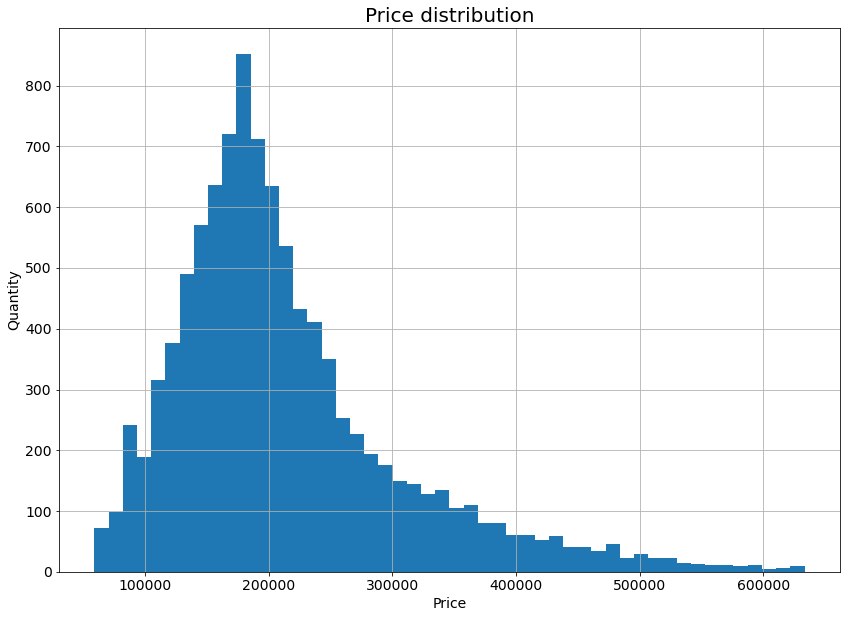

In [11]:
#Целевая переменная
plt.figure(figsize=(14,10))
train_df['Price'].hist(bins=50)
plt.xlabel('Price')
plt.ylabel('Quantity')
plt.title('Price distribution', fontsize=20)
plt.show()

In [12]:
train_df.info() #смотрим на данные

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [13]:
# Приведение типов
train_df['Id'] = train_df['Id'].astype('str')
train_df['DistrictId'] = train_df['DistrictId'].astype('str')
test_df['Id'] = test_df['Id'].astype('str')
test_df['DistrictId'] = test_df['DistrictId'].astype('str')

In [14]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)# минимизируем данные

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.69 MB
Decreased by 54.7%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.32 MB
Decreased by 55.6%


In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  category
 1   DistrictId     10000 non-null  category
 2   Rooms          10000 non-null  float16 
 3   Square         10000 non-null  float16 
 4   LifeSquare     7887 non-null   float16 
 5   KitchenSquare  10000 non-null  float16 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float16 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float16 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float16 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [16]:
preprocessor = DataPreprocessor()
preprocessor.fit(train_df)
train_df = preprocessor.transform(train_df)
preprocessor.fit(test_df)
test_df = preprocessor.transform(test_df)

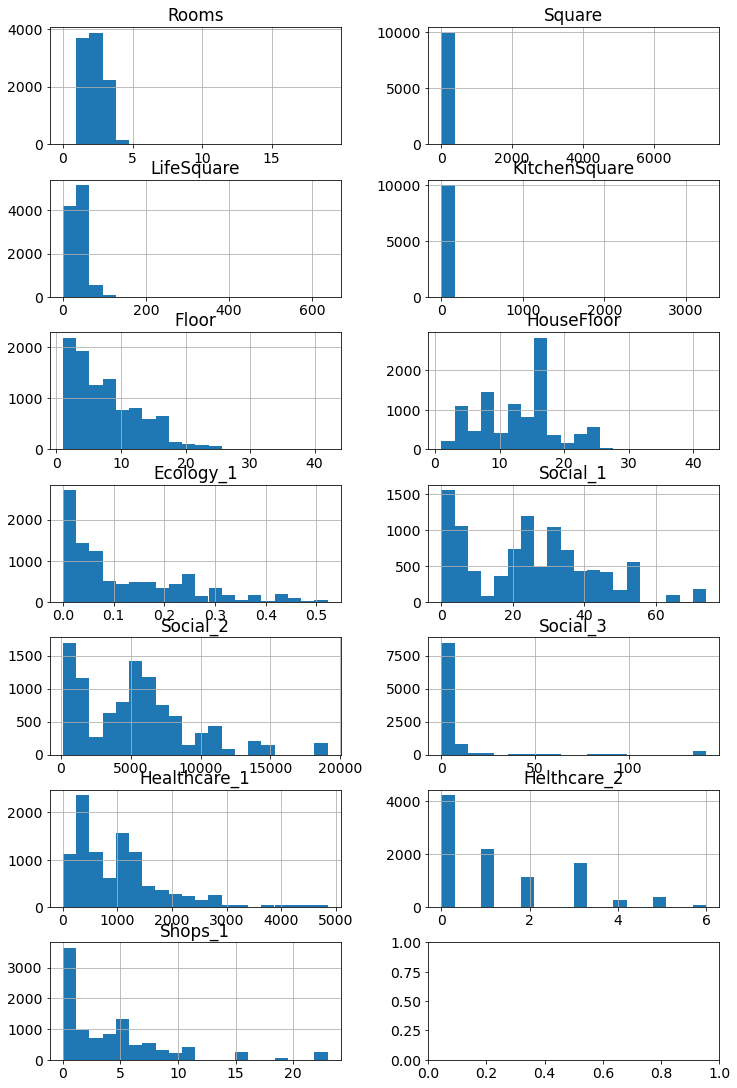

In [17]:
# Смотрим на другие признаки
numeric_cols = ['int16', 'float16', 'int8', 'int32', 'float32']
train_numeric = train_df.select_dtypes(include = numeric_cols)
train_numeric.drop('Price', axis='columns', inplace=True)
fig, axes = plt.subplots(nrows=7,ncols=2)
for col, axis in zip(train_numeric.columns, axes.flatten()):
    train_numeric.hist(column = col, bins=20, ax=axis)
fig.set_size_inches(12, 19)

In [18]:
train_df_target = train_df['Price']
train_df.drop(columns='Price', axis=1, inplace=True)
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,27,3.0,115.00000,75.625000,10.0,4.0,10.0,2014.0,0.075439,1,1,11,3097,0,455.25,0,0,1
1,22,1.0,39.84375,23.171875,8.0,7.0,8.0,1966.0,0.118530,1,1,30,6207,1,1183.00,1,0,1
2,1,3.0,78.31250,47.687500,10.0,2.0,17.0,1988.0,0.025604,1,1,33,5261,0,240.00,3,1,1
3,1,1.0,40.40625,28.375000,5.0,10.0,22.0,1977.0,0.007122,1,1,1,264,0,414.75,0,1,1
4,94,2.0,64.31250,38.562500,9.0,16.0,16.0,1972.0,0.282715,1,1,33,8667,2,1535.00,0,6,1


## Тренируем модель и прогнозируем

In [19]:
x_train, x_test, y_train, y_test = train_test_split(train_df, train_df_target, test_size=0.3, random_state=232)

In [20]:
rf_model = RandomForestRegressor(random_state=21,
                                 criterion='mse',
                                 n_estimators=3000,
                                 min_samples_split=4,
                                 min_samples_leaf=1,
                                 max_features='sqrt',
                                 max_depth=10,
                                 bootstrap=True)
rf_model.fit(x_train, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=4,
                      n_estimators=3000, random_state=21)

In [21]:
pred_train = rf_model.predict(x_train)
pred_test = rf_model.predict(x_test)

Train R2:	0.837
Test R2:	0.716


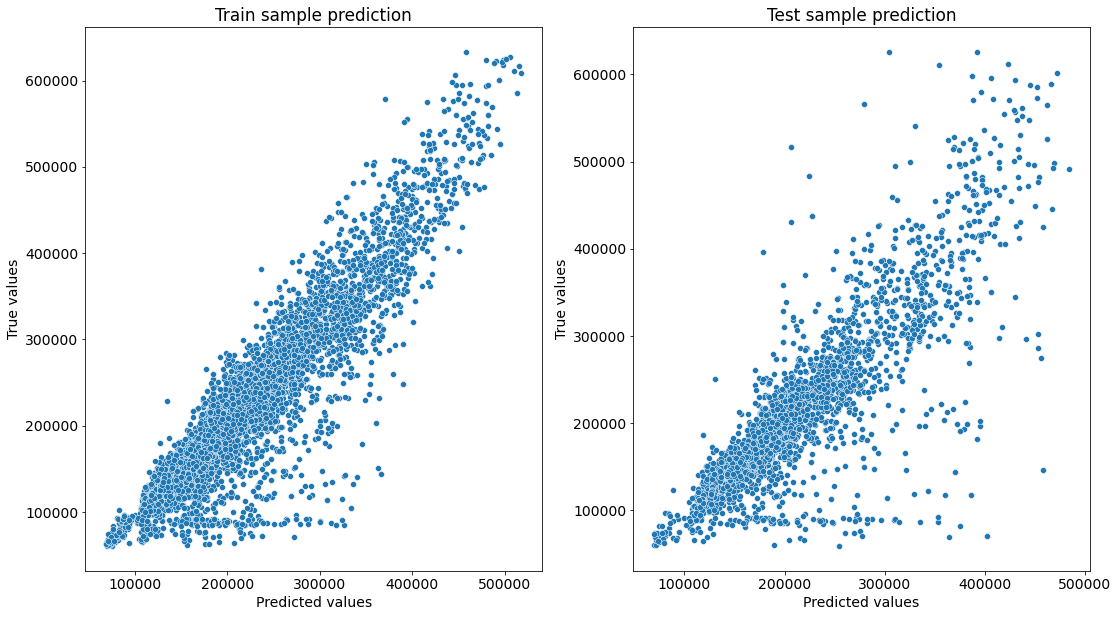

In [22]:
evaluate_preds(y_train, pred_train, y_test, pred_test) #Проверяем 

## Прогнозирование на submit

In [24]:
submit = pd.read_csv('../input/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [25]:
predictions = rf_model.predict(test_df)
predictions

array([158223.78946608, 128784.84242579, 167255.10590556, ...,
       153540.22034273, 185860.25377392, 259309.05253198])

In [26]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,158223.789466
1,5925,128784.842426
2,960,167255.105906
3,3848,137589.338564
4,746,216450.066523


In [27]:
submit.to_csv('rf_submit.csv', index=False)